# Maritime Trade: MLP
## Train 2019 + 2020 Test 2019 + 2020
### Hyperparameter Optimization - Keras Tuner

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
# Install and import packages
!pip install --upgrade pip
!pip install category_encoders
!pip install tensorflow
!pip install keras-tuner
import os
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import keras_tuner
from keras_tuner import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
my_dpi = 96
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

TensorFlow version: 2.9.1
Eager execution is: True
Keras version: 2.9.0
Num GPUs Available:  1


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Sat Dec 10 22:56:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   43C    P8    1

In [ ]:
# Reproducibility in TF and Pytorch
def init_seeds(seed=1920):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=1920)

In [ ]:
%cd /datasets/maritime_trade1920

/datasets/maritime_trade1920


In [ ]:
# Read data
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
df = df.drop_duplicates()
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633772, 20)


In [ ]:
# Create year-week for stratification
df['DateTime']= pd.to_datetime(df['DateTime'])
df['DateTime_YearWeek'] = df['DateTime'].dt.strftime('%Y-w%U')

In [ ]:
# Prepare 2019 for partitioning data
X = df.drop(['Metric_Tons', 'DateTime', 'Year'], axis=1)
y = df['Metric_Tons']

In [ ]:
# Set up train/test split with stratified by 'DateTime_YearWeek'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=X.DateTime_YearWeek,
                                                    random_state=1920)

In [ ]:
# Drop time variable
X_train = X_train.drop(['DateTime_YearWeek'], axis=1)
X_test = X_test.drop(['DateTime_YearWeek'], axis=1)

In [ ]:
# Encode variables using ranking - ordinal
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'US_company_size'])
X_train = ce_ord.fit_transform(X_train)
X_test = ce_ord.fit_transform(X_test)

In [ ]:
# Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print('Dimensions of X_train for input:', X_train.shape[1])

Dimensions of X_train for input: 34


In [ ]:
# Standard Scaling
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_test = pd.DataFrame(sc.transform(X_test))

# Hyperparameter Optimization: 20 Trials with 1 Epoch

In [ ]:
%cd /notebooks/MaritimeTrade/Models/DL/MLP/Models

/notebooks/MaritimeTrade/Models/DL/MLP/Models


In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

## HPO3: Batch=16, Layers: 4 - 10, Layer Size: 20 - 70

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 4, 10)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=20, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_1920_HPO3sc',
    project_name='MLP_Trade'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 10, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 10m 24s]
val_loss: 8.734837532043457

Best val_loss So Far: 8.734837532043457
Total elapsed time: 03h 21m 38s


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_1920_HPO3sc/MLP_1920_HPO3
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 70
layer_size3: 70
learning_rate: 0.0001
layer_size4: 20
layer_size5: 70
layer_size6: 70
layer_size7: 70
layer_size8: 70
layer_size9: 20
Score: 8.734837532043457
Trial summary
Hyperparameters:
num_layers: 9
layer_size0: 35
layer_size1: 70
layer_size2: 60
layer_size3: 40
learning_rate: 0.001
layer_size4: 65
layer_size5: 45
layer_size6: 20
layer_size7: 20
layer_size8: 20
Score: 8.742620468139648
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 20
layer_size3: 70
learning_rate: 0.0001
layer_size4: 20
layer_size5: 70
layer_size6: 20
layer_size7: 70
layer_size8: 70
layer_size9: 20
Score: 8.773947715759277
Trial summary
Hyperparameters:
num_layers: 10
layer_size0: 70
layer_size1: 70
layer_size2: 20
layer_size3: 20
learning_rate: 0.0001
layer_size4: 20
layer_size5: 70
layer_size6: 70

### Fit best model - Batch Size = 32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_b32_sc_epochs30_HPO3batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dense_4 (Dense)             (None, 20)                1420      
                                                                 
 dense_5 (Dense)             (None, 70)                1470      
                                                                 
 dense_6 (Dense)             (None, 70)                4

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
132676/132676 [==============================] - 334s 3ms/step - loss: 10.7225 - mse: 647.6578 - val_loss: 9.0364 - val_mse: 469.8859
Epoch 2/30
132676/132676 [==============================] - 336s 3ms/step - loss: 9.3472 - mse: 475.4253 - val_loss: 8.2922 - val_mse: 409.5208
Epoch 3/30
132676/132676 [==============================] - 340s 3ms/step - loss: 8.8937 - mse: 438.2385 - val_loss: 8.1096 - val_mse: 391.8342
Epoch 4/30
132676/132676 [==============================] - 336s 3ms/step - loss: 8.6578 - mse: 419.0550 - val_loss: 7.7961 - val_mse: 370.2580
Epoch 5/30
132676/132676 [==============================] - 318s 2ms/step - loss: 8.5093 - mse: 405.1537 - val_loss: 7.6437 - val_mse: 353.2334
Epoch 6/30
132676/132676 [==============================] - 326s 2ms/step - loss: 8.4000 - mse: 395.1307 - val_loss: 7.5194 - val_mse: 341.6541
Epoch 7/30
132676/132676 [==============================] - 322s 2ms/step - loss: 8.2992 - mse: 386.3290 - val_loss: 7.4765 - val_mse: 

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO3batch16_train1920_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1920_b32_sc_epochs30_HPO3batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch32_sc_30Epochs_HPO3batch16_train1920_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

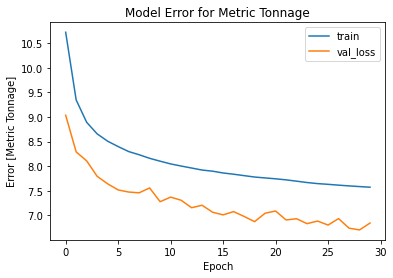

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

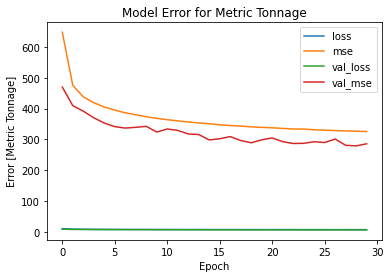

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(5307017, 1)

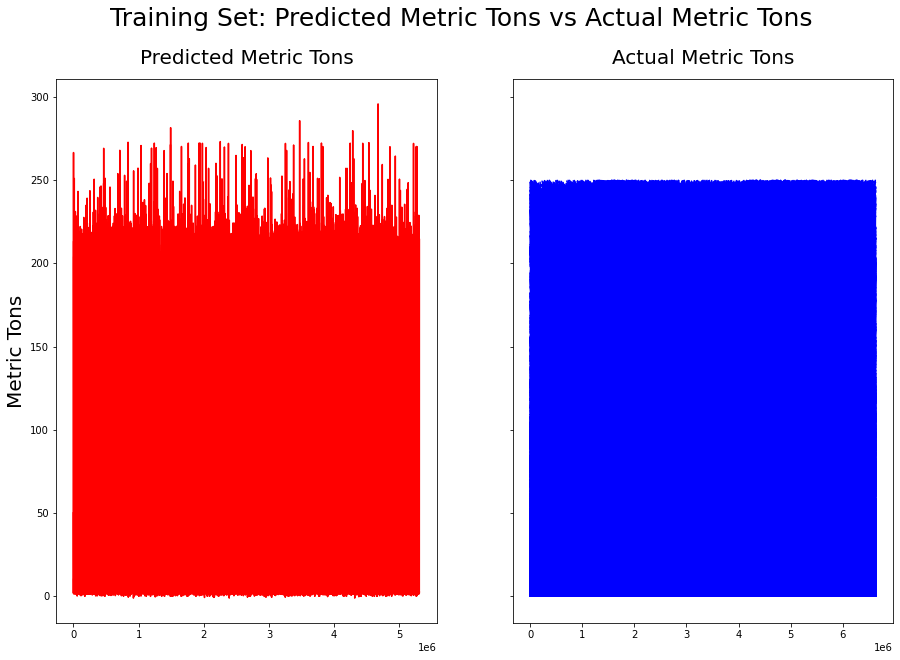

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

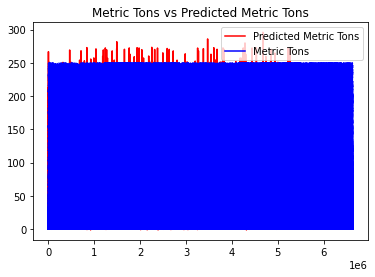

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(1326755, 1)

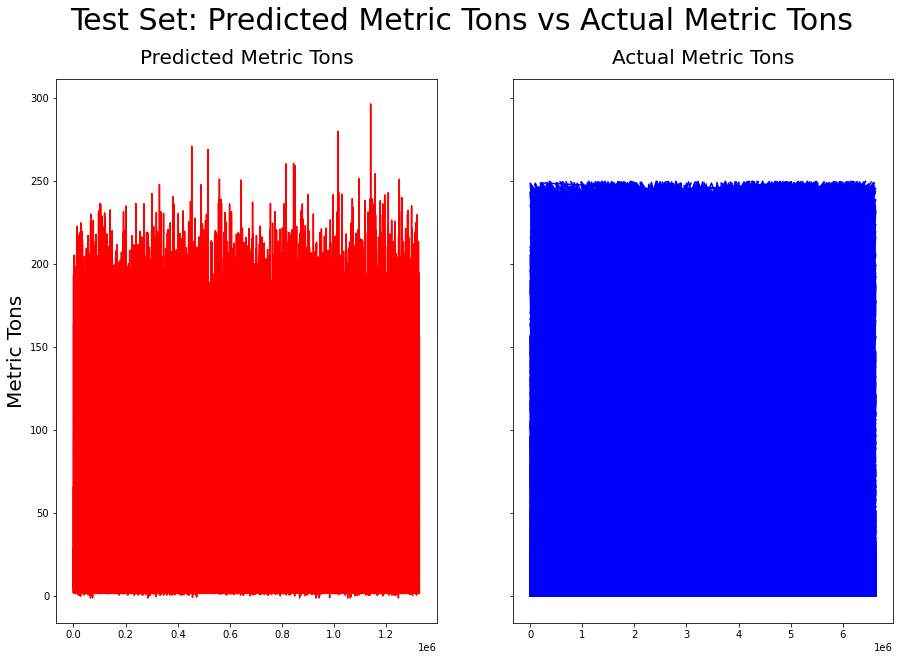

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

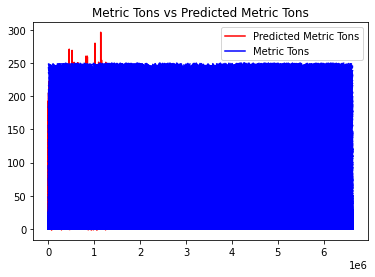

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO3batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.800085
MSE: 283.188068
RMSE: 16.828193
R2: 0.709382


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 9.338053
MSE: 506.277308
RMSE: 22.500607
R2: 0.483659


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 296.52792

Average Metric Tons: 21.748173950729406
Predicted Average Metric Tons: 17.446037

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -1.3577509


### Fit best model - Batch Size = 64

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_b64_sc_epochs30_HPO3batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 70)                4970      
                                                                 
 dense_4 (Dense)             (None, 20)                1420      
                                                                 
 dense_5 (Dense)             (None, 70)                1470      
                                                                 
 dense_6 (Dense)             (None, 70)                4

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
66338/66338 [==============================] - 227s 3ms/step - loss: 11.1701 - mse: 669.1032 - val_loss: 9.2757 - val_mse: 492.6187
Epoch 2/30
66338/66338 [==============================] - 224s 3ms/step - loss: 9.5785 - mse: 493.4982 - val_loss: 8.6300 - val_mse: 430.4992
Epoch 3/30
66338/66338 [==============================] - 231s 3ms/step - loss: 9.0967 - mse: 450.9369 - val_loss: 8.2891 - val_mse: 395.5729
Epoch 4/30
66338/66338 [==============================] - 228s 3ms/step - loss: 8.8226 - mse: 429.6795 - val_loss: 8.0820 - val_mse: 387.4580
Epoch 5/30
66338/66338 [==============================] - 239s 4ms/step - loss: 8.6031 - mse: 413.6848 - val_loss: 7.7408 - val_mse: 360.7241
Epoch 6/30
66338/66338 [==============================] - 232s 4ms/step - loss: 8.4424 - mse: 400.3586 - val_loss: 7.5959 - val_mse: 346.8620
Epoch 7/30
66338/66338 [==============================] - 216s 3ms/step - loss: 8.3298 - mse: 391.0380 - val_loss: 7.5748 - val_mse: 352.3881
Epoch

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO3batch16_train1920_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1920_b64_sc_epochs30_HPO3batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch64_sc_30Epochs_HPO3batch16_train1920_tf.h5')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

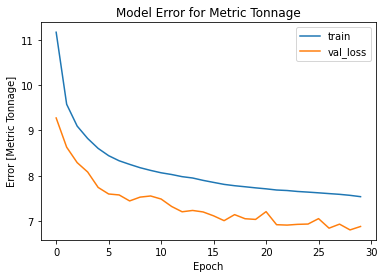

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

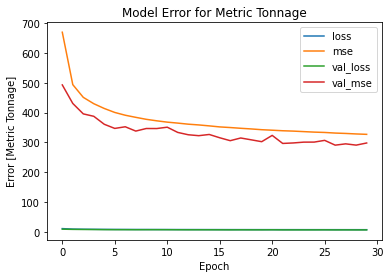

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(5307017, 1)

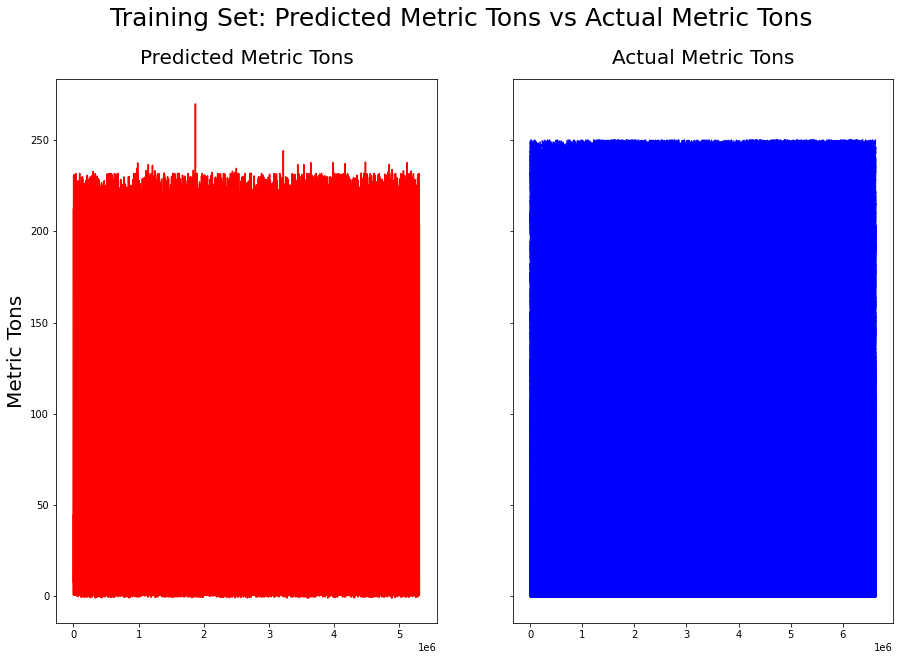

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

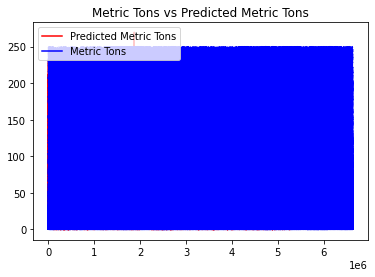

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(1326755, 1)

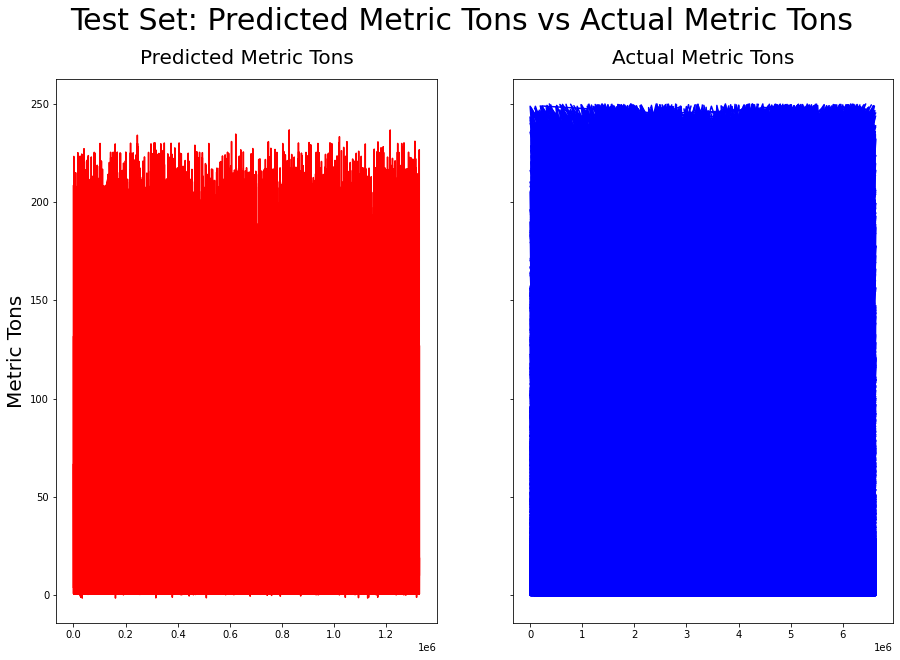

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

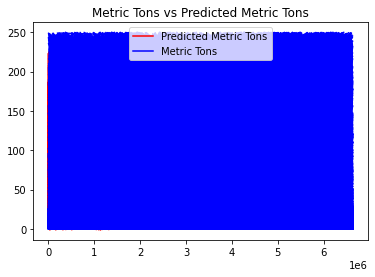

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch64_sc_30Epochs_HPO3batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.835094
MSE: 295.137396
RMSE: 17.179563
R2: 0.697120


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.976296
MSE: 493.170397
RMSE: 22.207440
R2: 0.497026


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 236.76253

Average Metric Tons: 21.748173950729406
Predicted Average Metric Tons: 18.03941

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -1.3822889


## HPO5: Batch Size=16 Layers:7-13 Layer Size: 40 - 70

In [ ]:
callbacks = [TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=1,
                         embeddings_freq=1)]

In [ ]:
# Define model for HPO
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 7, 13)):
        model.add(tf.keras.layers.Dense(units=hp.Int('layer_size' + str(i),
                                                     min_value=40, max_value=70,
                                                     step=5),
                                        activation='relu',
                                        kernel_initializer='normal'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(Dense(1))
  model.compile(loss='mae', metrics=['mse'], optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
# Define the search conditions
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='MLP_1920_HPO5sc',
    project_name='MLP_1920_HPO5'
)

In [ ]:
# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 7, 'max_value': 13, 'step': 1, 'sampling': None}
layer_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size2 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size3 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size4 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size5 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
layer_size6 (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 70, 'step': 5, 'sampling': None}
learning_rate (C

In [ ]:
# Begin the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16,
             callbacks=callbacks)

Trial 20 Complete [00h 10m 51s]
val_loss: 8.724970817565918

Best val_loss So Far: 8.63400650024414
Total elapsed time: 03h 50m 03s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Retrieve the best model(s)
models = tuner.get_best_models(num_models=2)

In [ ]:
# Print a summary of the results from the trials
tuner.results_summary()

Results summary
Results in MLP_1920_HPO5sc/MLP_1920_HPO5
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
layersize0: 70
layersize1: 70
layersize2: 70
layersize3: 40
layersize4: 40
layersize5: 40
layersize6: 70
learning_rate: 0.0001
layersize7: 45
layersize8: 60
layersize9: 55
layersize10: 60
layersize11: 70
layersize12: 70
Score: 8.63400650024414
Trial summary
Hyperparameters:
num_layers: 7
layersize0: 70
layersize1: 70
layersize2: 45
layersize3: 40
layersize4: 40
layersize5: 70
layersize6: 70
learning_rate: 0.0001
layersize7: 70
layersize8: 50
layersize9: 70
layersize10: 70
layersize11: 70
layersize12: 70
Score: 8.644169807434082
Trial summary
Hyperparameters:
num_layers: 7
layersize0: 65
layersize1: 70
layersize2: 70
layersize3: 70
layersize4: 40
layersize5: 40
layersize6: 55
learning_rate: 0.0001
layersize7: 70
layersize8: 40
layersize9: 40
layersize10: 40
layersize11: 70
layersize12: 70
Score: 8.64748477935791
Trial summary
Hyperparameters:
num_layers: 7
layersi

### Fit best model - Batch Size = 32

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_b32_sc_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 40)                2840      
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
132676/132676 [==============================] - 320s 2ms/step - loss: 10.3435 - mse: 598.3653 - val_loss: 8.9975 - val_mse: 479.5851
Epoch 2/30
132676/132676 [==============================] - 317s 2ms/step - loss: 8.9807 - mse: 459.0904 - val_loss: 8.4535 - val_mse: 413.7636
Epoch 3/30
132676/132676 [==============================] - 321s 2ms/step - loss: 8.4569 - mse: 414.3028 - val_loss: 8.0546 - val_mse: 394.2274
Epoch 4/30
132676/132676 [==============================] - 316s 2ms/step - loss: 8.1596 - mse: 393.2281 - val_loss: 7.7254 - val_mse: 369.9892
Epoch 5/30
132676/132676 [==============================] - 313s 2ms/step - loss: 7.9829 - mse: 381.0190 - val_loss: 7.5631 - val_mse: 368.7254
Epoch 6/30
132676/132676 [==============================] - 314s 2ms/step - loss: 7.8485 - mse: 368.5930 - val_loss: 7.5286 - val_mse: 360.4175
Epoch 7/30
132676/132676 [==============================] - 312s 2ms/step - loss: 7.7395 - mse: 359.0845 - val_loss: 7.4708 - val_mse: 

In [ ]:
# Save model
model.save('./MLP_batch32_sc_30Epochs_HPO5batch16_train1920_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1920_b32_sc_epochs30_HPO5batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch32_sc_30Epochs_HPO5batch16_train1920_tf.h5')
# model.load_weights(filepath)

# Show the model architecture
#model.summary()

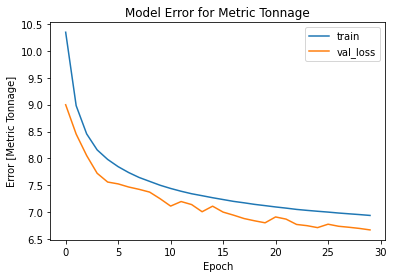

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

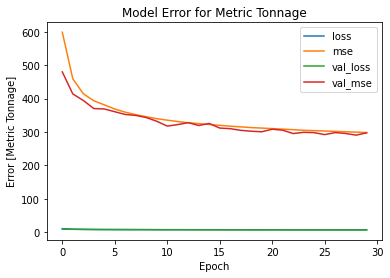

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

165845/165845 [==============================] - 165s 992us/step


(5307017, 1)

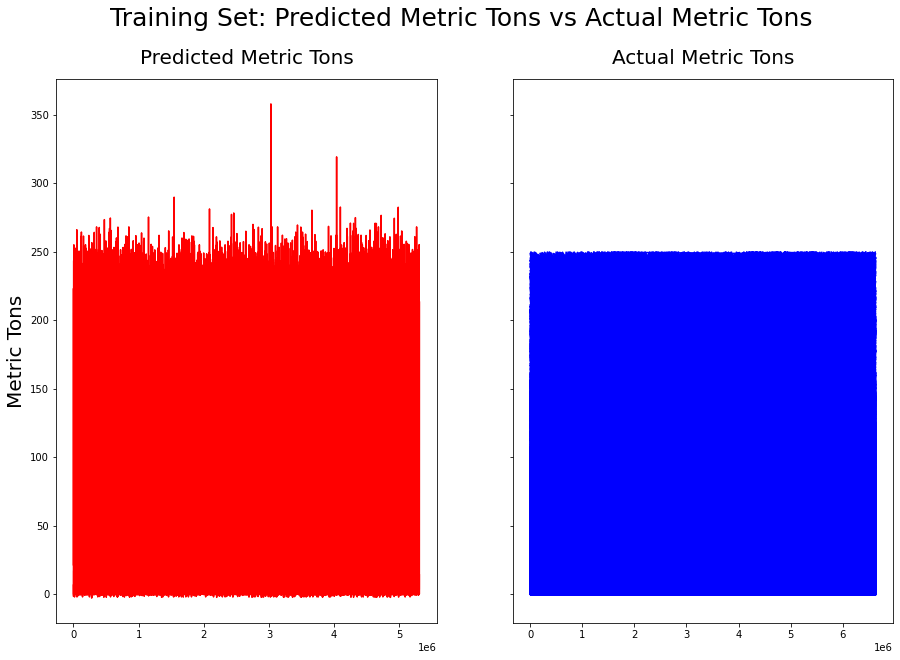

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

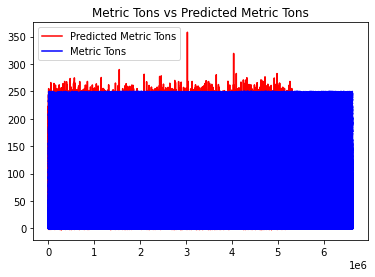

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

41462/41462 [==============================] - 40s 952us/step


(1326755, 1)

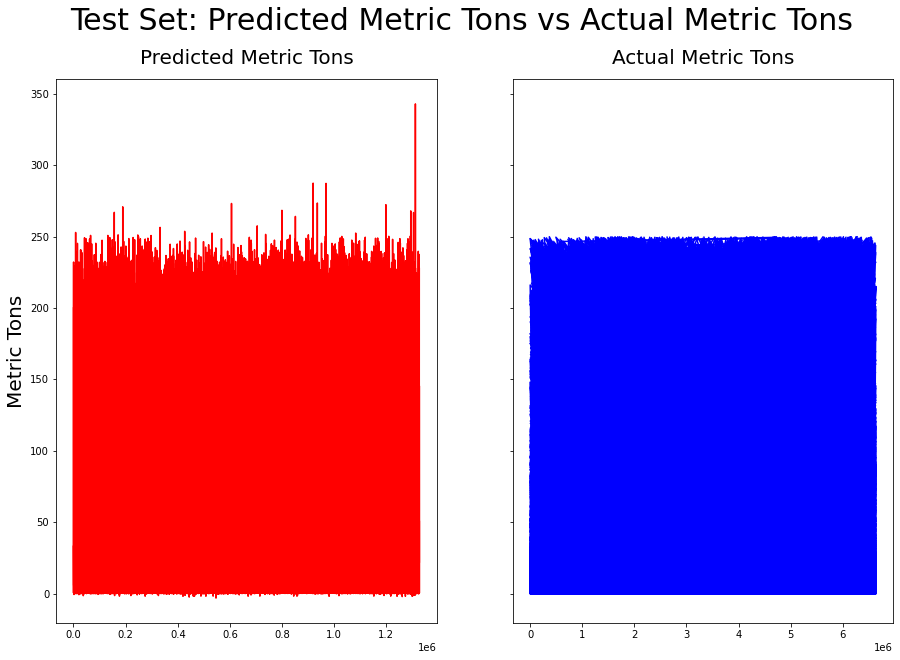

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

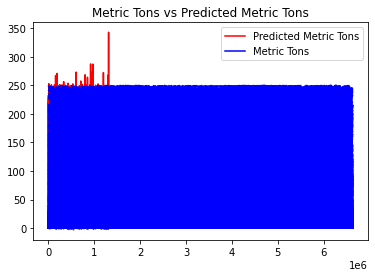

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch32_sc_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.627989
MSE: 291.917125
RMSE: 17.085582
R2: 0.700752


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 8.088076
MSE: 404.663076
RMSE: 20.116239
R2: 0.585491


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 342.98853

Average Metric Tons: 21.723412551676827
Predicted Average Metric Tons: 19.303293

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -3.215115


### Fit best model - Batch Size = 16

In [ ]:
log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

%load_ext tensorboard

In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_b64_epochs30_HPO5batch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience=5),
                  ModelCheckpoint(filepath, monitor='mse',
                                  save_freq='epoch'),
                  tensorboard_callback]

In [ ]:
# Model architecture
model = Sequential()
model.add(Dense(70, input_dim=34, kernel_initializer='normal',
                activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dense(70, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                2450      
                                                                 
 dense_1 (Dense)             (None, 70)                4970      
                                                                 
 dense_2 (Dense)             (None, 70)                4970      
                                                                 
 dense_3 (Dense)             (None, 40)                2840      
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 70)                2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/30
66338/66338 [==============================] - 207s 3ms/step - loss: 10.7499 - mse: 663.6588 - val_loss: 9.2106 - val_mse: 499.7888
Epoch 2/30
66338/66338 [==============================] - 203s 3ms/step - loss: 9.1161 - mse: 467.1057 - val_loss: 8.5688 - val_mse: 435.8699
Epoch 3/30
66338/66338 [==============================] - 202s 3ms/step - loss: 8.6266 - mse: 425.0562 - val_loss: 8.2670 - val_mse: 399.9667
Epoch 4/30
66338/66338 [==============================] - 201s 3ms/step - loss: 8.3198 - mse: 402.2017 - val_loss: 7.9806 - val_mse: 378.2114
Epoch 5/30
66338/66338 [==============================] - 201s 3ms/step - loss: 8.1232 - mse: 387.7635 - val_loss: 7.7459 - val_mse: 368.3380
Epoch 6/30
66338/66338 [==============================] - 200s 3ms/step - loss: 7.9823 - mse: 377.8965 - val_loss: 7.6542 - val_mse: 354.8209
Epoch 7/30
66338/66338 [==============================] - 199s 3ms/step - loss: 7.8793 - mse: 371.1259 - val_loss: 7.5519 - val_mse: 355.7680
Epoch

In [ ]:
# Save model
model.save('./MLP_batch64_sc_30Epochs_HPO5batch16_train1920_tf.h5',
           save_format='tf')

# Load model for more training or later use
#filepath = 'MLP_weights_only_train1920_b64_epochs30_HPO5batch16.h5'
#model = tf.keras.models.load_model('./MLP_batch64_sc_30Epochs_HPO5batch16_train1920_tf.h5'')
#model.load_weights(filepath)

# Show the model architecture
#model.summary()

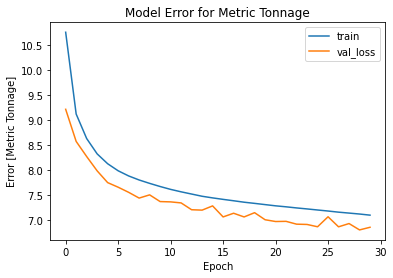

In [ ]:
# Plot loss over epochs
plt.title('Model Error for Metric Tonnage')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Train1920_batch64_30Epochs_HPO5batch16_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

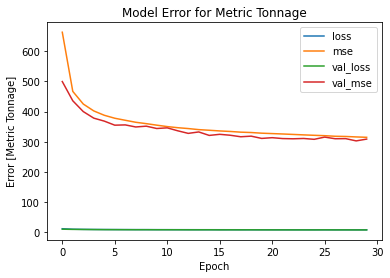

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.title('Model Error for Metric Tonnage')
plt.ylabel('Error [Metric Tonnage]')
plt.xlabel('Epoch')
plt.savefig('Train1920_batch64_30Epochs_HPO5batch16_LossValLoss.png',
            dpi=my_dpi*10, bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

165845/165845 [==============================] - 222s 1ms/step


(5307017, 1)

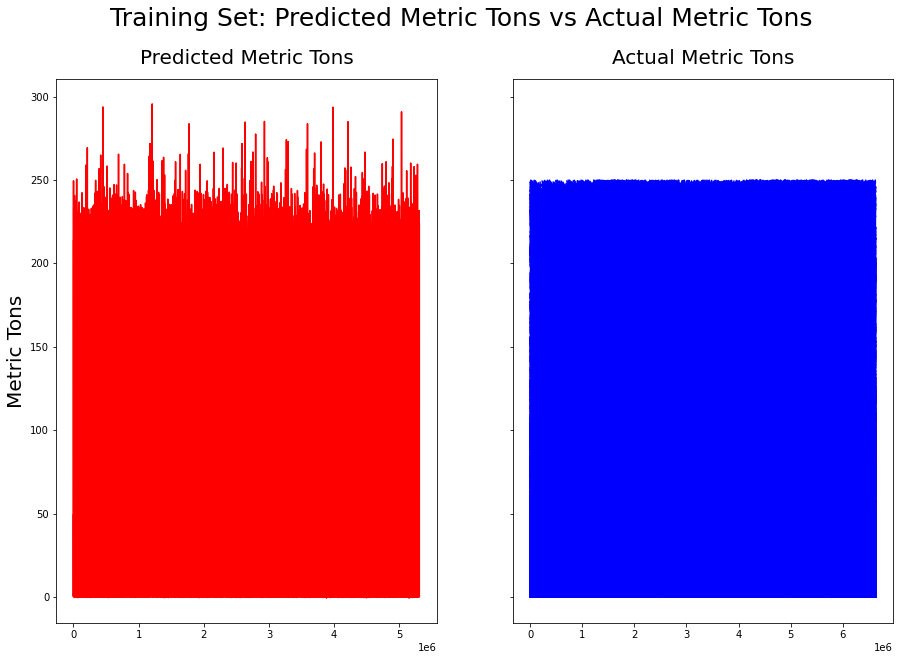

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize=25)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch64_30Epochs_HPO5batch16_PredictedActual_Train_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

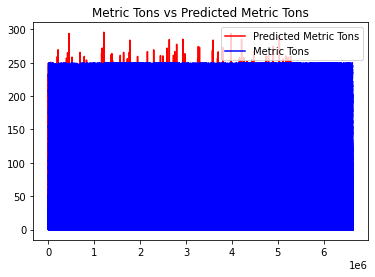

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_train, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch64_30Epochs_HPO5batch16_PredictedActual_Train_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

41462/41462 [==============================] - 59s 1ms/step


(1326755, 1)

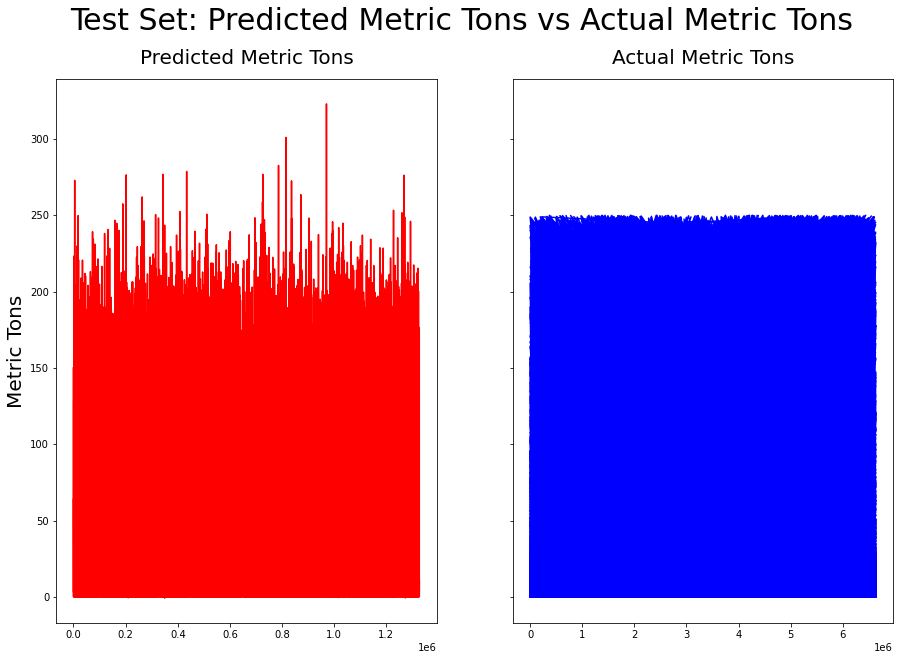

In [ ]:
# Graph predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize=30)
ax1.plot(y_pred, color='red')
ax1.set_title('Predicted Metric Tons', pad=15, fontsize=20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color='blue')
ax2.set_title('Actual Metric Tons', pad=15, fontsize=20)
plt.show()

In [ ]:
# Save file separately due 'OverflowError: In draw_path: Exceeded cell block limit'
f.savefig('Train1920_batch64_30Epochs_HPO5batch16_PredictedActual_Test_Side.png',
          dpi=my_dpi*10, bbox_inches='tight')

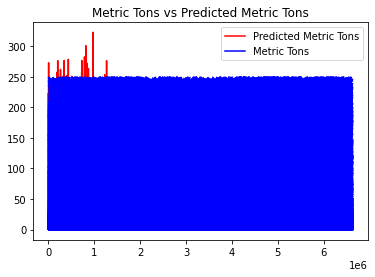

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set
plt.rcParams['agg.path.chunksize'] = 10000
plt.title('Metric Tons vs Predicted Metric Tons')
plt.plot(y_pred, color='red', label='Predicted Metric Tons')
plt.plot(y_test, color='blue', label='Metric Tons')
plt.legend()
plt.savefig('Train1920_batch64_30Epochs_HPO5batch16_PredictedActual_Test_Overlaid.png',
            dpi=my_dpi*10, bbox_inches='tight')
plt.show()

In [ ]:
# Metrics from training model
print('Metrics: Train set')
print('MAE: %3f' % mean_absolute_error(y_train[:], pred_train[:]))
print('MSE: %3f' % mean_squared_error(y_train[:], pred_train[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_train[:], pred_train[:])))
print('R2: %3f' % r2_score(y_train[:], pred_train[:]))

Metrics: Train set
MAE: 6.811886
MSE: 305.976566
RMSE: 17.492186
R2: 0.685996


In [ ]:
# Metrics from test set
print('Metrics: Test set')
print('MAE: %3f' % mean_absolute_error(y_test[:], pred_test[:]))
print('MSE: %3f' % mean_squared_error(y_test[:], pred_test[:]))
print('RMSE: %3f' % np.sqrt(mean_squared_error(y_test[:], pred_test[:])))
print('R2: %3f' % r2_score(y_test[:], pred_test[:]))

Metrics: Test set
MAE: 9.115483
MSE: 517.635917
RMSE: 22.751614
R2: 0.472074


In [ ]:
# Actual/Predicted maximum, average and minimum metric tonnage
print('Maximum Metric Tons:', np.amax(y_test))
print('Predicted Max Metric Tons:', np.amax(pred_test))
print('\nAverage Metric Tons:', np.average(y_test))
print('Predicted Average Metric Tons:', np.average(pred_test))
print('\nMinimum Metric Tons:', np.amin(y_test))
print('Predicted Minimum Metric Tons:', np.amin(pred_test))

Maximum Metric Tons: 249.98
Predicted Max Metric Tons: 322.84283

Average Metric Tons: 21.748173950729406
Predicted Average Metric Tons: 17.835443

Minimum Metric Tons: 0.0
Predicted Minimum Metric Tons: -0.5787697
